**Resumen Ejecutivo**

**Análisis Predictivo de Supervivencia en el Titanic**

**Objetivo:**

Desarrollar un modelo predictivo que determine la probabilidad de supervivencia de pasajeros del Titanic, basado en características demográficas y sociales.

**Modelos Evaluados**

Se entrenaron y evaluaron tres modelos supervisados:

**1. Regresión logística**
**2. Árbol de decisión**
**3. Random Forest**

**Selección del Modelo Final**

El modelo de Random Forest fue seleccionado como el mejor debido a:

1. Mejor desempeño global con una precisión del 76% en el conjunto de prueba.
2. Equilibrio adecuado entre precisión y sensibilidad para ambas clases (sobrevivientes y no sobrevivientes).
3. Capacidad para manejar relaciones no lineales y variables categóricas de manera efectiva.

**Variables Clave**

El análisis de importancia de variables indicó que las más influyentes para la predicción fueron:

1. Sexo — factor determinante en la supervivencia.
2. Tarifa pagada (Fare) — correlacionada con la clase y ubicación en el barco.
3. Edad — afecta la probabilidad de supervivencia.
4. Clase social (Pclass)
5. Familiares a bordo (Hermanos/esposos y padres/hijos)

**Conclusiones**

1. El modelo Random Forest obtuvo la mejor precisión (≈76%) en la predicción de supervivencia, superando tanto a la regresión logística como al árbol de decisión.
2. Las variables más relevantes para predecir la supervivencia coinciden con el conocimiento histórico y social del Titanic (ej. prioridad para mujeres y niños, clase social).
3. La matriz de confusión muestra que los modelos tienen más dificultad en predecir correctamente los casos de supervivencia (clase minoritaria), lo que sugiere la necesidad de posibles mejoras con técnicas como balanceo de clases o ajuste de umbrales.

# 1. Cargar librerías

In [73]:
# --- Manipulación de datos ---
import pandas as pd
import numpy as np

# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuración global de estilo y visualización ---
sns.set_theme(style="whitegrid", palette="Set2", font_scale=1.1)

# --- Manejo de advertencias ---
import warnings
warnings.filterwarnings('ignore')


# Trabajar con dataset Titanic

In [74]:
# Cargar el dataset
df = pd.read_csv('titanic.csv')

# Vista preliminar
df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


#  2. Exploración general del dataset

In [75]:
# Dimensiones del dataset
print("Dimensiones:", df.shape)

# Información general
df.info()

# Estadísticas generales
df.describe(include='all')

# Valores faltantes
print("\nValores nulos por columna:")
print(df.isnull().sum())


Dimensiones: (887, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Name                     887 non-null    object 
 3   Sex                      887 non-null    object 
 4   Age                      887 non-null    float64
 5   Siblings/Spouses Aboard  887 non-null    int64  
 6   Parents/Children Aboard  887 non-null    int64  
 7   Fare                     887 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.6+ KB

Valores nulos por columna:
Survived                   0
Pclass                     0
Name                       0
Sex                        0
Age                        0
Siblings/Spouses Aboard    0
Parents/Children Aboard    0
Fare                       0
dtype: int6

# 3. Análisis exploratorio básico

3.1 Distribución de la variable objetivo (survived)

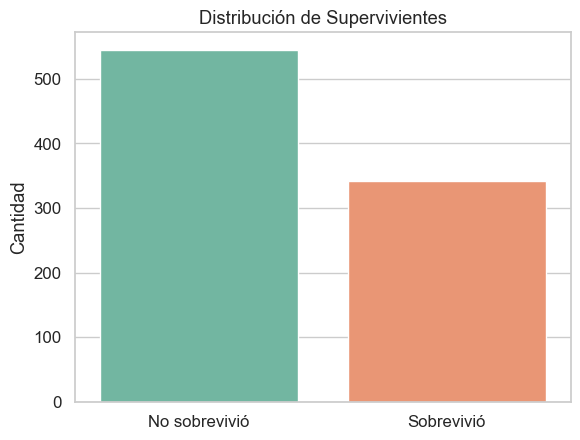

In [76]:

palette_2 = ["#66c2a5", "#fc8d62"]  # Verde suave y naranja suave

# Convertimos a string para que el eje se vea más claro
df['Survived_str'] = df['Survived'].map({0: 'No sobrevivió', 1: 'Sobrevivió'})

# Usamos tanto x como hue en la misma variable
sns.countplot(x='Survived_str', hue='Survived_str', data=df, palette=palette_2)
plt.title('Distribución de Supervivientes')
plt.xlabel('')
plt.ylabel('Cantidad')
plt.legend([],[], frameon=False)  # Ocultar la leyenda redundante
plt.show()




3.2 Supervivencia según sexo

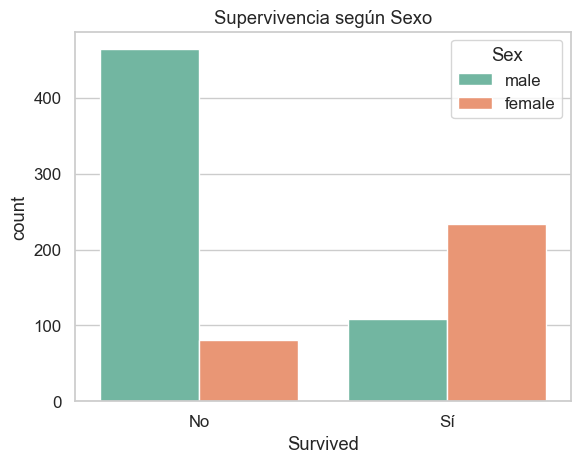

In [77]:
sns.countplot(x='Survived', hue='Sex', data=df)
plt.title('Supervivencia según Sexo')
plt.xticks([0, 1], ['No', 'Sí'])
plt.show()

3.3 Supervivencia por clase

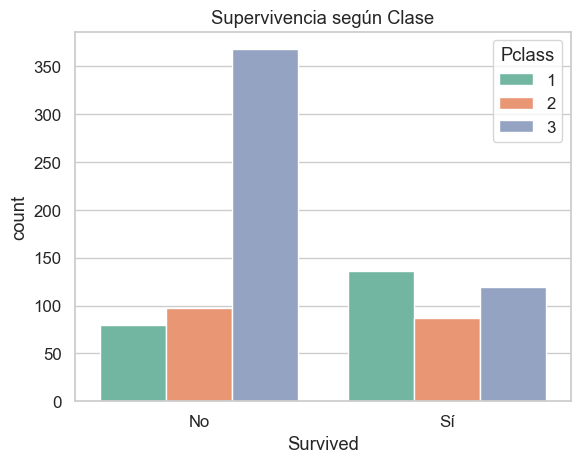

In [78]:

custom_palette = ["#66c2a5", "#fc8d62", "#8da0cb"]  # Set2 base

sns.countplot(x='Survived', hue='Pclass', data=df, palette=custom_palette)
plt.title('Supervivencia según Clase')
plt.xticks([0, 1], ['No', 'Sí'])
plt.show()

3.4 Distribución de la edad

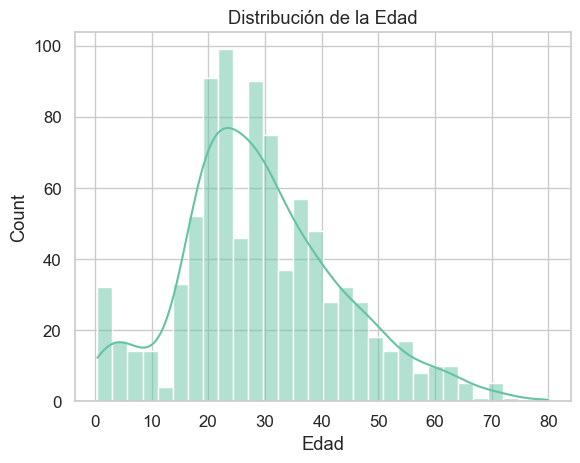

In [79]:
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Distribución de la Edad')
plt.xlabel('Edad')
plt.show()


3.5 Correlaciones numéricas

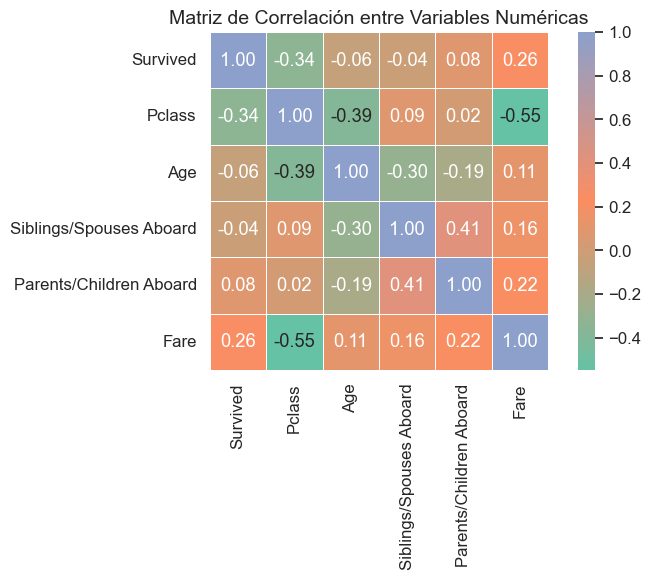

In [80]:

from matplotlib.colors import LinearSegmentedColormap

# Calcular la matriz de correlación
corr = df.corr(numeric_only=True)

# Crear un mapa de color personalizado similar a la paleta Set2
colors = ["#66c2a5", "#fc8d62", "#8da0cb"]  # Verde suave, naranja, azul suave
cmap_custom = LinearSegmentedColormap.from_list("custom_set2", colors, N=100)

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap=cmap_custom, fmt=".2f", linewidths=0.5, square=True)
plt.title('Matriz de Correlación entre Variables Numéricas', fontsize=14)
plt.tight_layout()
plt.show()



# 4. Preparar datos para modelamiento

In [81]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

# 1. Copia del dataset original
df_model = df.copy()

# 2. Eliminar columnas que no usaremos y la columna 'Survived_str' si existe
df_model.drop('Name', axis=1, inplace=True)
if 'Survived_str' in df_model.columns:
    df_model.drop('Survived_str', axis=1, inplace=True)

# 3. Codificar 'Sex'
le = LabelEncoder()
df_model['Sex'] = le.fit_transform(df_model['Sex'])  # male=1, female=0

# 4. Separar X e y
X = df_model.drop('Survived', axis=1)
y = df_model['Survived']

# 5. División entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mostrar información resumen
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Primeras 5 filas de X_train:\n", X_train.head())
print("\nPrimeros 5 valores de y_train:\n", y_train.head())



Dimensiones de X_train: (709, 6)
Dimensiones de X_test: (178, 6)
Primeras 5 filas de X_train:
      Pclass  Sex   Age  Siblings/Spouses Aboard  Parents/Children Aboard  \
730       2    1  23.0                        0                        0   
390       3    1  28.0                        2                        0   
118       3    0   2.0                        4                        2   
440       2    0  28.0                        0                        0   
309       1    0  18.0                        2                        2   

        Fare  
730   13.000  
390    7.925  
118   31.275  
440   13.000  
309  262.375  

Primeros 5 valores de y_train:
 730    0
390    0
118    0
440    1
309    1
Name: Survived, dtype: int64


# 5. Modelo de Regresión logística

Accuracy en test: 0.7528089887640449

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.76      0.87      0.82       111
           1       0.73      0.55      0.63        67

    accuracy                           0.75       178
   macro avg       0.74      0.71      0.72       178
weighted avg       0.75      0.75      0.74       178


Matriz de confusión:
 [[97 14]
 [30 37]]


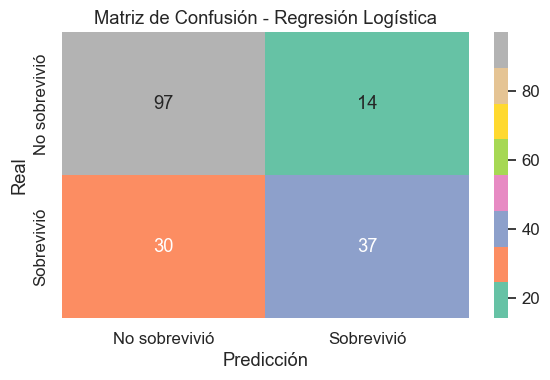

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Crear el modelo
model_log = LogisticRegression(max_iter=1000, random_state=42)

# Entrenar con los datos de entrenamiento
model_log.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model_log.predict(X_test)

# Evaluar desempeño
print("Accuracy en test:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualización coherente con la del árbol
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Set2",
            xticklabels=['No sobrevivió', 'Sobrevivió'],
            yticklabels=['No sobrevivió', 'Sobrevivió'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Regresión Logística')
plt.tight_layout()
plt.show()



# 6. Modelo de Árbol de decisión

Accuracy Árbol de Decisión: 0.7359550561797753

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.81      0.76      0.78       111
           1       0.64      0.70      0.67        67

    accuracy                           0.74       178
   macro avg       0.72      0.73      0.72       178
weighted avg       0.74      0.74      0.74       178


Matriz de confusión:
 [[84 27]
 [20 47]]


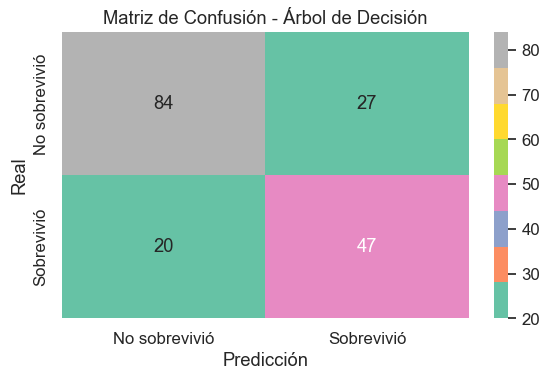

In [89]:
from sklearn.tree import DecisionTreeClassifier

# Crear el modelo
model_tree = DecisionTreeClassifier(random_state=42)

# Entrenar
model_tree.fit(X_train, y_train)

# Predecir
y_pred_tree = model_tree.predict(X_test)

# Evaluar
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy Árbol de Decisión:", accuracy_score(y_test, y_pred_tree))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred_tree))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred_tree))
df_model.shape

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusión
cm_tree = confusion_matrix(y_test, y_pred_tree)

# Visualización
plt.figure(figsize=(6,4))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap="Set2", xticklabels=['No sobrevivió', 'Sobrevivió'], yticklabels=['No sobrevivió', 'Sobrevivió'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.tight_layout()
plt.show()


# 7. Random Forest

Accuracy Random Forest: 0.7640449438202247

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.81      0.82      0.81       111
           1       0.69      0.67      0.68        67

    accuracy                           0.76       178
   macro avg       0.75      0.75      0.75       178
weighted avg       0.76      0.76      0.76       178



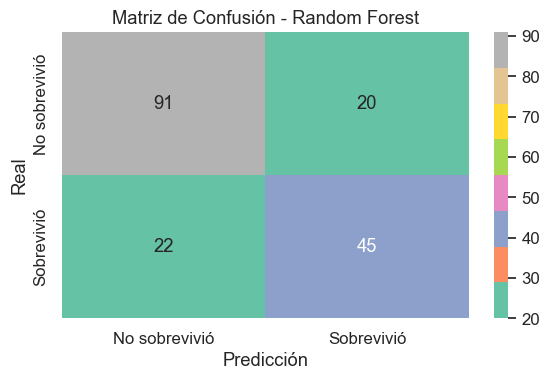

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Entrenar el modelo Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Predecir sobre el set de prueba
y_pred_rf = model_rf.predict(X_test)

# Métricas de evaluación
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy Random Forest:", accuracy_rf)
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred_rf))

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Visualización igual a la del árbol de decisión
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap="Set2",
            xticklabels=['No sobrevivió', 'Sobrevivió'],
            yticklabels=['No sobrevivió', 'Sobrevivió'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Random Forest')
plt.tight_layout()
plt.show()


| Modelo              | Accuracy | Precisión (Clase 1) | Recall (Clase 1) | F1-Score (Clase 1) |
| ------------------- | -------- | ------------------- | ---------------- | ------------------ |
| Regresión Logística | \~0.75   | 0.73                | 0.55             | 0.63               |
| Árbol de Decisión   | \~0.74   | 0.64                | 0.70             | 0.67               |
| Random Forest       | \~0.76   | 0.69                | 0.67             | 0.68               |


# 8. Importancia variables en Random Forest

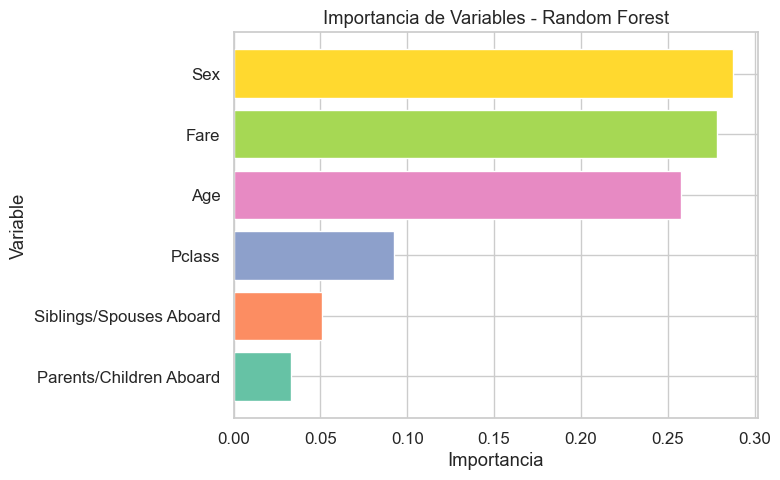

In [97]:
# Obtener la importancia de variables del modelo Random Forest
importances = model_rf.feature_importances_

# Crear DataFrame para ordenarlas mejor
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=True)

# Visualización con paleta Set2
plt.figure(figsize=(8,5))
colors = sns.color_palette("Set2", len(feature_importance_df))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color=colors)
plt.title('Importancia de Variables - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()




**Conclusiones Finales**

1. Aunque los modelos predicen con buena precisión, todavía presentan dificultades para identificar correctamente a los sobrevivientes (clase minoritaria). Esto sugiere que podrían mejorarse mediante técnicas de balanceo o modelos más complejos.
2. La limpieza y codificación adecuada de los datos, así como la selección de variables relevantes, fueron fundamentales para lograr resultados efectivos.
3. Se aconseja explorar otros modelos avanzados como XGBoost o SVM, realizar validación cruzada para mayor robustez y desarrollar nuevas características basadas en el contexto histórico y social para mejorar la capacidad predictiva.

# 9. Predicción de supervivencia para pasajeros hipotéticos

In [98]:
# Crear nuevo DataFrame con 3 nuevos pasajeros (mismo formato que X_train)
nuevos_pasajeros = pd.DataFrame({
    'Pclass': [1, 1, 1],  # Clase alta
    'Sex': [1, 0, 0],     # Hombre=1, Mujer=0, Niño=0
    'Age': [30, 28, 8],   # Edades: hombre adulto, mujer adulta, niño
    'Siblings/Spouses Aboard': [0, 0, 1],  # Suponiendo el niño con 1 hermano/esposo
    'Parents/Children Aboard': [0, 0, 2],  # El niño con 2 padres
    'Fare': [100, 100, 100]  # Tarifa alta fija (puedes ajustar)
})

# Predecir con el modelo Random Forest
predicciones = model_rf.predict(nuevos_pasajeros)

# Mostrar resultados
for i, pred in enumerate(predicciones):
    estado = "Sobrevivió" if pred == 1 else "No sobrevivió"
    print(f"Pasajero {i+1}: {estado}")


Pasajero 1: No sobrevivió
Pasajero 2: Sobrevivió
Pasajero 3: Sobrevivió
